# Free Market, UBI and CCT policies were analysed

In [156]:
from ai_economist import foundation
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from tutorials.utils import plotting 
from gymnasium import spaces
import time
import pandas as pd
from ai_economist.foundation.scenarios.utils import social_metrics

In [2]:
from copy import deepcopy
import numpy as np
from ai_economist.foundation.base.base_component import (
    BaseComponent,
    component_registry,
)

#Universal Basic Income and Conditional Cash Transfer functionality is added
#using this component
@component_registry.add
class ubi_target_redistribution(BaseComponent):
    #name of the component
    name = "ubi_target_redistribution"
    #entities used in this component
    required_entities = ["Coin"]
    agent_subclasses = ["BasicMobileAgent"]

    def __init__(self, *base_env_args, policy_type="ubi", not_train_planner = True, **base_env_kwargs):
        super().__init__(*base_env_args, **base_env_kwargs)
        self.max_period = 12
        self.current_period = 1
        self.no_agents = len(self.world.agents)
        self.last_income = [0 for _ in range(self.no_agents)]
        self.current_income = [0 for _ in range(self.no_agents)]
        self.current_income_without_tax = [0 for _ in range(self.no_agents)]
        self.current_tax_amount = [0 for _ in range(self.no_agents)] 
        self.tax_rate = [0 for _ in range(self.no_agents)]
        self.agent_funds = [0 for _ in range(self.no_agents)]
        self.treasury = 0
        self.income_target_threshold = 11
        self.ubi_amount = 1
        self.sufficient_treasury_amount = 50
        self.type = policy_type
        self.min_tax_rate_income = [0, 6, 21, 51]
        self.max_tax_rate_income = [5, 20, 50, 5999]
        self.max_tax_rate = 0.73
        self.current_tax_rate = [0, 0.20, 0.40, 0.5]
        # if not_train_planner is set to true then planner agent will not be trained
        #this functionality was used in curriculum learning
        self.not_train_planner = not_train_planner


    #get_n_actions is used to get available actions for planner agent
    def get_n_actions(self, agent_cls_name):
        if agent_cls_name == "BasicPlanner":
            actions = [('start', 10), ('base', 10), ('higher', 10), ('additional', 10)]
            return actions
        return 0

    #get_tax_on_action if planner doesn't choose any action
    #previous tax rate is assigned
    def get_tax_on_action(self, action, tax_bracket_type):
        if action == 0:
            return self.get_bracket_tax_by_type(tax_bracket_type)
        return action/10


    #this function is triggered for every trainsition in the environment
    def component_step(self):
        if self.not_train_planner:
            return
 
        if self.current_period >= self.max_period:
            #tax is enacted if the current period reaches last month
            self.enact_tax()
            self.current_period = 1
        else:
            self.current_period = self.current_period + 1
        #wealth is redistributed for every step
        self.redistribute_wealth()
       

    # the redistribution policy will be executed based on policy type
    def redistribute_wealth(self):
        if self.type == "ubi":
            self.ubi_redistribute()
        elif self.type == "target_transfer":
            self.target_redistribute()

    # based on planner action tax rate is returned
    def tax_rate_based_on_action(self, action):
        start_tax_rate = self.get_tax_on_action(action[0], "start")
        base_tax_rate = self.get_tax_on_action(action[1], "base")
        higher_tax_rate = self.get_tax_on_action(action[2], "higher")
        additional_tax_rate = self.get_tax_on_action(action[3], "additional")

        return [start_tax_rate, base_tax_rate, higher_tax_rate, additional_tax_rate]


    # current tax rate is retuned based on tax band
    def get_bracket_tax_by_type(self, tax_bracket_type):
        if tax_bracket_type == "start":
            return self.current_tax_rate[0]
        elif tax_bracket_type == "base":
            return self.current_tax_rate[1]
        elif tax_bracket_type == "higher":
            return self.current_tax_rate[2]
        elif tax_bracket_type == "additional":
            return self.current_tax_rate[3]
        
    # lower tax rate was masked based on provided tax band
    def mask_lower_tax_bracket(self, tax_bracket_type):
        current_tax_rate = self.get_bracket_tax_by_type(tax_bracket_type)
        return self.mask_lower_rate(current_tax_rate, False)
   
    # higher tax rates was masked based on provided tax band
    def mask_higher_tax_bracket(self, tax_bracket_type):
        current_tax_rate = self.get_bracket_tax_by_type(tax_bracket_type)
        return self.mask_higher_rate(current_tax_rate, False)
    
    # higher tax rate was maked 
    def mask_higher_rate(self, tax_rate, open_interval):
        value = int(max((tax_rate * 10)-1, 0))
        
        exclude_value = 0
        if open_interval:
            exclude_value = 1
            
        mask = np.zeros(10)
        for i in range(value - exclude_value, -1, -1):
            mask[i] = 1
        return mask
    
    # lower tax rate was masked
    def mask_lower_rate(self, tax_rate, open_interval):
        value = int(max((tax_rate * 10)-1, 0))
        
        exclude_value = 0
        if open_interval:
            exclude_value = 1
            
        mask = np.ones(10)
        for i in range(value - exclude_value, -1, -1):
            mask[i] = 0
        return mask
    
    #action mask for the planner agent is returned based on 
    #treasury conditions and current period
    #if the current period is not tax period all the
    #planner actions were set to invalid    
    def get_action_mask(self):
         
        if self.current_period != 12:
            return {
            "start" : np.zeros(10),
            "base" : np.zeros(10),
            "higher" : np.zeros(10),
            "additional" : np.zeros(10)
        }

        if self.treasury <= 0:
            return {
            "start" : self.mask_lower_tax_bracket("start"),
            "base" : self.mask_lower_tax_bracket("base"),
            "higher" : self.mask_lower_tax_bracket("higher"),
            "additional" : self.mask_lower_tax_bracket("additional")
        }
        
        if self.treasury >= self.sufficient_treasury_amount:
            return {
            "start" : self.mask_higher_tax_bracket("start"),
            "base" : self.mask_higher_tax_bracket("base"),
            "higher" : self.mask_higher_tax_bracket("higher"),
            "additional" : self.mask_higher_tax_bracket("additional")
        }
        
        return {
            "start" : np.ones(10),
            "base" : np.ones(10),
            "higher" : np.ones(10),
            "additional" : np.ones(10)
        }



    # get the current tax rate based on income
    def get_tax_rate_income(self, income):
        min_income = [0, 12, 50, 125]
        max_income = [11, 49, 126, 5999]
        tax_rate = self.current_tax_rate
        
        no_options = len(tax_rate)

        for i in range(no_options):
            if income >= min_income[i] and income <= max_income[i]:
                return tax_rate[i]

        return tax_rate[no_options - 1]

    # mariginal tax amount is calculated based on income
    def get_marginal_taxed_amount(self, income):
        tax_calculated_amount = 0
        remaining_amount_cal = income
        tax_amount = 0
        for i, max_amount in enumerate(self.max_tax_rate_income):
            if income > max_amount:
                amount_to_cal_tax = max_amount
                amount_to_cal_tax = amount_to_cal_tax - tax_calculated_amount
                tax_amount = self.current_tax_rate[i] * amount_to_cal_tax + tax_amount
                tax_calculated_amount = tax_calculated_amount + amount_to_cal_tax
                remaining_amount_cal = remaining_amount_cal - amount_to_cal_tax
            elif remaining_amount_cal > 0:
                tax_amount = self.current_tax_rate[i] * remaining_amount_cal + tax_amount
                remaining_amount_cal = 0
        return tax_amount

    #tax amount is calculated enacted based on agents income using this function
    def enact_tax(self):
        world = self.world
        yearly_treasury_collection = 0
        self.last_income = self.current_income.copy()
        action = self.world.planner.get_component_action(self.name)
        self.current_tax_rate = self.tax_rate_based_on_action(action)
        for i, agent in enumerate(world.agents):
            previous_income = self.last_income[agent.idx]
            total_income = agent.state["inventory"]["Coin"] + agent.state["escrow"]["Coin"]
            current_income = max(0, total_income - previous_income)
                
            self.current_income_without_tax[i] = current_income
            
            tax_rate = self.get_tax_rate_income(current_income)
            self.tax_rate[i] = tax_rate
            tax_amount = self.get_marginal_taxed_amount(current_income)
            self.current_tax_amount[i] = tax_amount
            
            if agent.state["inventory"]["Coin"] > tax_amount:
                agent.state["inventory"]["Coin"] = agent.state["inventory"]["Coin"] - tax_amount
            else:
                agent.state["inventory"]["Coin"] = 0
                
            self.current_income[i] = current_income - tax_amount
            yearly_treasury_collection = yearly_treasury_collection + tax_amount
        self.treasury = self.treasury + yearly_treasury_collection
        
        
    #the funds were distributed based on UBI policy
    def ubi_redistribute(self):
        world = self.world
        ubi_expense = 0
        for i, agent in enumerate(world.agents):
            agent.state["inventory"]["Coin"] = agent.state["inventory"]["Coin"] + self.ubi_amount
            ubi_expense = ubi_expense + self.ubi_amount
            self.agent_funds[i] = self.ubi_amount
        self.treasury = self.treasury - ubi_expense
    
    # agents wealth is calculated using proxy means test
    def proxy_means_test(self, agent, income):

        stone =  agent.state["escrow"]["Stone"]

        wood = agent.state["escrow"]["Wood"]
        
        proxy_mean_test_value =  income + (stone * 2.5) + (wood * 2.5)

        return proxy_mean_test_value

    # funds were redistributed based on CCT policy
    def target_redistribute(self):
        world = self.world
        target_fund_expense = 0
        no_agents_low_income = 0
        total_agents = 0
        
        for i, agent in enumerate(world.agents):
            agent_current_income = self.current_income[i]
            total_agents = total_agents + 1
            if self.proxy_means_test(agent, agent_current_income) <= self.income_target_threshold:
                no_agents_low_income = no_agents_low_income + 1     
        amount_equal_UBI_expense = self.ubi_amount * total_agents
     
        target_fund_low_income_indv = 0
        if no_agents_low_income > 0:
               target_fund_low_income_indv = amount_equal_UBI_expense / no_agents_low_income
        
        for i, agent in enumerate(world.agents):
            agent_current_income = self.current_income[i]
            if self.proxy_means_test(agent, agent_current_income) <= self.income_target_threshold:
                target_fund_expense = target_fund_expense + target_fund_low_income_indv
                agent.state["inventory"]["Coin"] = agent.state["inventory"]["Coin"] + target_fund_low_income_indv
                self.agent_funds[i] = target_fund_low_income_indv
            else:
                self.agent_funds[i] = 0
                
        self.treasury = self.treasury - target_fund_expense

    # observations for agents were returned by this function on every transition step
    def generate_observations(self):
        world = self.world
        obs = dict()
        first_day = float(self.current_period == 1)
        tax_day = float(self.current_period == self.max_period)
        obs["p"] = dict(
            period=self.current_period,
            first_day=first_day,
            tax_day=tax_day,
            treasury_amount=self.treasury,
            tax_bracket = self.current_tax_rate,
            agent_incomes = self.last_income,
            agent_tax_amounts = self.current_tax_amount,
            agent_tax_rate = self.tax_rate,
            current_income_without_tax = self.current_income_without_tax
        )

        for i, agent in enumerate(world.agents):
            obs[agent.idx] = dict(
                tax_day=tax_day,
                last_income=self.last_income[i],
                tax_rate=self.tax_rate[i],
                tax_amount=self.current_tax_amount[i],
                tax_bracket = self.current_tax_rate[i],
                current_income_without_tax = self.current_income_without_tax[i]
            )
            
        return obs

    # this function is triggered for every transition
    # action mask values were returned
    def generate_masks(self, completions=0):
        action_mask = self.get_action_mask()
        
        masks = {"p" : action_mask}
        
        return masks


In [3]:
from ray.rllib.env.multi_agent_env import MultiAgentEnv
from gymnasium import spaces
from gym.utils import seeding
import random
import math
import numpy as np
import hashlib
import warnings
import copy
from IPython import display
 
from ray.rllib.utils.annotations import override


'''
This function is taken from the source 
https://github.com/salesforce/ai-economist/blob/master/tutorials/rllib/env_wrapper.py 
'''

def recursive_list_to_np_array(d):
    if isinstance(d, dict):
        new_d = {}
        for k, v in d.items():
            if isinstance(v, list):
                new_d[k] = np.array(v)
            elif isinstance(v, dict):
                new_d[k] = recursive_list_to_np_array(v)
            elif isinstance(v, (float, int, np.floating, np.integer)):
                new_d[k] = np.array([v])
            elif isinstance(v, np.ndarray):
                new_d[k] = v
            else:
                raise AssertionError
        return new_d
    raise AssertionError


'''
The EconomicsWrapper class is used to add multi-agent functionality to the simulation
environment. MultiAgentEnv class is inherited to facillitate multi-agent reinforcement 
learning using PPO policy
'''
class EconomicsWrapper(MultiAgentEnv):

    def __init__(self, env_config): 
        #ai-economist environment instance is passed      
        self.env = env_config["env"]
        #train_only_agents is true then only the worker agent will be trained 
        #the planner agent reward will be set to 0 
        self.train_only_agents = env_config["train_only_agents"]
        self._agent_ids = set(self.get_agent_ids())
        self._infos = {}
        self.last_obs = {}
        self.terminateds = set()
        self.truncateds = set()
        self.current_task = 0
        #max_curriculum_reward curriculum reward threshold if the current reward
        #is above threshold value then the current curriculum task is achieved 
        self.max_curriculum_reward = 5

        self.sum_of_reward = 0
        self.curriculum_condition_satisfied = False
        super().__init__()

    def get_agent_ids(self):
        agents = []
        for agent in self.env.all_agents:
            agents.append(str(agent.idx))
        return set(agents)


    '''
        distance between two points in the 2 dimensional space is calculated using
        distance_between_points funciton
    ''' 
    def distance_between_points(self, x1, y1, x2, y2):
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        return distance

    '''
        checks is there resource nearby
    '''
    def no_resource_near(self, x1, y1, resource_arr, within_distance):
        resource = 0
        for x, row in enumerate(resource_arr):
            for y, val in enumerate(row):
                if val == 1 and self.distance_between_points(x, y, x1, y1) <= within_distance:
                    resource = resource +  1
        return resource

    '''
        this funciton is used to get agent location agent location 
    '''
    def get_agent_loc(self):
        x_loc = []
        y_loc = []
        for agent_id in self._agent_ids:
            row, col = self.env.world.maps.get_agent_location(int(agent_id))
            x_loc.append(row)
            y_loc.append(col)
        return x_loc, y_loc
       
    '''
        this funciton is used check is there any resource near by
    '''
    def agent_resources_near(self, agent_id, within_distance):
        stone_obs = self.last_obs["p"]["world-map"][0]
        wood_obs = self.last_obs["p"]["world-map"][1]
        row, col = self.env.world.maps.get_agent_location(int(agent_id))
        no_stone_resource = self.no_resource_near(row, col, stone_obs, within_distance)
        no_wood_resource = self.no_resource_near(row, col, wood_obs, within_distance)
        return no_stone_resource, no_wood_resource
   
    '''
        checks is agent contains the given number of resource
    '''
    def is_agent_contains_resource(self, agent_id, within_distance, no_of_resource):
        no_stone_resource, no_wood_resource = self.agent_resources_near(agent_id, within_distance)
        if(no_stone_resource >= no_of_resource or no_wood_resource >= no_of_resource):
            return True
        else:
            return False

    '''
        this funciton is used check if all agents contain resource
    '''
    def is_all_agent_contains_resource(self, within_distance, no_of_resource):
        agents = ["0", "1", "2", "3"]
        for agent_id in agents:
            is_agent_contains_resource = self.is_agent_contains_resource(agent_id, within_distance, no_of_resource)
            if not is_agent_contains_resource:
                return False
        return True

    
    '''
    this funciton is used to reset the simulation environment
    '''
    def reset(self, *, seed=None, options=None):
        self.terminateds = set()
        self.truncateds = set()
        self._observations = {}
        self._infos = {}
        self.sum_of_reward = 0
        obs = self.env.reset()
        self.last_obs = copy.deepcopy(obs)
        obs_dict = {}
        for agent in self._agent_ids:
            obs_agent = obs[agent]
            obs_agent = self.seperate_world_map_obs(obs_agent, agent)
            obs_dict[agent] = recursive_list_to_np_array(obs_agent)
        return obs_dict,  self._infos



    def seed(self, seed):
        # Using the seeding utility from OpenAI Gym
        # https://github.com/openai/gym/blob/master/gym/utils/seeding.py
        _, seed1 = seeding.np_random(seed)
        # Derive a random seed. This gets passed as an uint, but gets
        # checked as an int elsewhere, so we need to keep it below
        # 2**31.
        seed2 = seed1 + 1 % 2 ** 31

        seed = int(seed2)
        np.random.seed(seed2)
        random.seed(seed2)
        self._seed = seed2   

    '''
        Every spatial information were concatenated  
    '''
    def seperate_world_map_obs(self, obs, agent):
        if agent == "p":
            del obs["world-idx_map"]
            del obs["world-map"]
            return obs
        world_map_dimension = len(obs["world-map"])
        concatenate_arr = np.concatenate((obs["world-map"], obs["world-idx_map"]), axis=0)
        obs["world-map"] = np.transpose(concatenate_arr, (1, 2, 0))
        del obs["world-idx_map"]

        return obs

    '''
        Every spatial information were concatenated this function
        is used to set observation space   
    '''
    @staticmethod
    def seperate_world_map_obs_(obs, agent):
        if agent == "p":
            del obs["world-idx_map"]
            del obs["world-map"]
            return obs
        world_map_dimension = len(obs["world-map"])
        concatenate_arr = np.concatenate((obs["world-map"], obs["world-idx_map"]), axis=0)
        obs["world-map"] = np.transpose(concatenate_arr, (1, 2, 0))
        del obs["world-idx_map"]
        return obs

    '''
        this funciton is triggered when simulation 
        environment transition to next state
    '''
    def step(self, action):
        obs, rewards, done, info = self.env.step(action)
        self.last_obs = copy.deepcopy(obs)
        obs_dict = {}
        for agent in self._agent_ids:
            obs_agent = obs[agent]
            obs_agent = self.seperate_world_map_obs(obs_agent, agent)
            obs_dict[agent] = recursive_list_to_np_array(obs_agent)
            if agent != "p":
                self.sum_of_reward = self.sum_of_reward + rewards[agent]
        end_iteration = False

        if self.train_only_agents and self.sum_of_reward >= self.max_curriculum_reward:
            self.curriculum_condition_satisfied = True
            done["__all__"] = True
        
        if self.train_only_agents:
            rewards['p'] = 0 

        if done["__all__"]:
            end_iteration = True   
        terminated = {agent_id: end_iteration for agent_id in self._agent_ids}
        truncated = {agent_id: end_iteration for agent_id in self._agent_ids}
        terminated["__all__"] = end_iteration
        truncated["__all__"] = end_iteration

        return obs_dict, rewards, terminated, truncated, info
    
            
    '''
        this funciton is used to get action space of agents
    '''
    @staticmethod
    def get_action_space(agent_id, env):
        if agent_id == 'p':
            if env.world.planner.multi_action_mode:
                return spaces.MultiDiscrete(env.get_agent(agent_id).action_spaces)
            else:
                return spaces.Discrete(env.get_agent(agent_id).action_spaces)
        else:
            if env.world.agents[agent_id].multi_action_mode:
                return spaces.MultiDiscrete(env.get_agent(agent_id).action_spaces)
            else:
                return spaces.Discrete(env.get_agent(agent_id).action_spaces)

    '''
        this funciton is used get observation space for an agent
    '''
    @staticmethod
    def get_observation_space(agent_id, obs):
        obs[agent_id] = EconomicsWrapper.seperate_world_map_obs_(obs[agent_id], agent_id)
        obs_space = EconomicsWrapper.dict_to_spaces_dict(obs[agent_id])
        
        return obs_space

    '''
        this funciton is taken from the source 
        https://github.com/salesforce/ai-economist/blob/master/tutorials/rllib/env_wrapper.py
    '''
    @staticmethod
    def dict_to_spaces_dict(obs):
        BIG_NUMBER = 10000
        dict_of_spaces = {}
        for k, v in obs.items():

            # list of lists are listified np arrays
            _v = v
            if isinstance(v, list):
                _v = np.array(v)
            elif isinstance(v, (int, float, np.floating, np.integer)):
                _v = np.array([v])

            # assign Space
            if isinstance(_v, np.ndarray):
                x = float(BIG_NUMBER)
                # Warnings for extreme values
                if np.max(_v) > x:
                    warnings.warn("Input is too large!")
                if np.min(_v) < -x:
                    warnings.warn("Input is too small!")
                box = spaces.Box(low=-x, high=x, shape=_v.shape, dtype=_v.dtype)
                low_high_valid = (box.low < 0).all() and (box.high > 0).all()

                # This loop avoids issues with overflow to make sure low/high are good.
                while not low_high_valid:
                    x = x // 2
                    box = spaces.Box(low=-x, high=x, shape=_v.shape, dtype=_v.dtype)
                    low_high_valid = (box.low < 0).all() and (box.high > 0).all()

                dict_of_spaces[k] = box

            elif isinstance(_v, dict):
                dict_of_spaces[k] = EconomicsWrapper.dict_to_spaces_dict(_v)
            else:
                raise TypeError
        return spaces.Dict(dict_of_spaces)



    


In [4]:
def recursive_list_to_np_array(obj):
    if isinstance(obj, dict):
        new_val = {}
        for key, val in obj.items():
            if isinstance(val, list):
                new_val[key] = np.array(val)
            elif isinstance(val, dict):
                new_val[key] = recursive_list_to_np_array(val)
            elif isinstance(val, (float, int, np.floating, np.integer)):
                new_val[key] = np.array([val])
            elif isinstance(val, np.ndarray):
                new_val[key] = val
            else:
                raise AssertionError
        return new_val
    raise AssertionError
    
def get_observation(agent_id, obs):
    obs_agent = EconomicsWrapper.seperate_world_map_obs_(obs[agent_id], agent_id)
    
    final_obs = recursive_list_to_np_array(obs_agent)
    return final_obs

In [151]:
#the given policies were simulated and observations were collected and returned as a dataframe
def economic_simulation(env, policy_type, data_frame, worker_algo, planner_algo):
    obs = env.reset(force_dense_logging = True)
    init_state =  state_0 = state_1 = state_2 = state_3 = state_p = [ np.zeros([20], np.float32) for _ in range(2)]

    for time_step in range(200):
        agent0_obs = get_observation("0", obs)
        agent0_action, state_out_0, _  = worker_algo.compute_single_action(observation = agent0_obs, policy_id="policy_0", state=state_0)

        agent1_obs = get_observation("1", obs)
        agent1_action, state_out_1, _ = worker_algo.compute_single_action(observation = agent1_obs, policy_id="policy_0", state=state_1)

        agent2_obs = get_observation("2", obs)
        agent2_action, state_out_2, _ = worker_algo.compute_single_action(observation = agent2_obs, policy_id="policy_0", state=state_2)

        agent3_obs = get_observation("3", obs)
        agent3_action, state_out_3, _ = worker_algo.compute_single_action(observation = agent3_obs, policy_id="policy_0", state=state_3)

        planner_obs = get_observation("p", obs)
        planner_action , state_out_p, _ = planner_algo.compute_single_action(observation = planner_obs, policy_id="policy_p", state=state_p)

        actions = {"0" : agent0_action, 
                   "1" : agent1_action,
                   "2" : agent2_action,
                   "3" : agent3_action,
                   "p" : planner_action
                  }

        obs, rew, done, info = env.step(actions)
        state_0 = state_out_0
        state_1 = state_out_1
        state_2 = state_out_2
        state_3 = state_out_3
        state_p = state_out_p
        
        coin_earned = np.array([agent.total_endowment("Coin") for agent in env.world.agents])
        productivity = social_metrics.get_productivity(coin_earned)
        equality = social_metrics.get_equality(coin_earned)
        
      
        agent_ids = ["0", "1", "2", "3"]   
        for index, agent_id in enumerate(agent_ids):
            row_ =  {"agent_id" : agent_id, 
             "time_step": time_step,
             "tax_amount": obs[agent_id]["ubi_target_redistribution-tax_amount"],
             "total_amount" : obs[agent_id]["ubi_target_redistribution-tax_amount"],
             "total_earnings" : env.all_agents[index].total_endowment("Coin"),
             "pre_tax_income" : obs[agent_id]["ubi_target_redistribution-current_income_without_tax"],
             "post_tax_income" : obs[agent_id]["ubi_target_redistribution-last_income"],
             "start_tax": obs['p']["ubi_target_redistribution-tax_bracket"][0],
             "base_tax": obs['p']["ubi_target_redistribution-tax_bracket"][1],
             "higher_tax" : obs['p']["ubi_target_redistribution-tax_bracket"][2],
             "additional_tax" : obs['p']["ubi_target_redistribution-tax_bracket"][3],
             "tax_period" :  obs['p']["ubi_target_redistribution-period"],
             "treasury_amount" : obs['p']["ubi_target_redistribution-treasury_amount"],
             "productivity" : productivity,
             "equality" : equality,
             "policy" : policy_type,
             "equality_X_productivity" : productivity * equality
                   }
                
            temp_df = pd.DataFrame([row_])
            data_frame = pd.concat([data_frame, temp_df], ignore_index=True)
            

        
    return data_frame
        

Free Market Policy Config

In [78]:
curr_env_config = {
   
    'scenario_name': 'layout_from_file/simple_wood_and_stone',
    'components': [
       
        ('Build', {'skill_dist': "pareto", 'payment_max_skill_multiplier': 1, 'build_labor':1, 'payment': 10}), 
        ('Gather', {'move_labor': 1, 'collect_labor': 1, 'skill_dist' : "pareto"}),
        ('ContinuousDoubleAuction', {
            'max_bid_ask':    10,
            'order_labor':    0.1,
            'max_num_orders': 4,
            'order_duration': 30
        }),
        ("ubi_target_redistribution", {'not_train_planner': True})
       
    ],
    
    'env_layout_file': 'env-pure_and_mixed-25X25.txt',
    'starting_agent_coin': 10,
    'fixed_four_skill_and_loc': True,
    'full_observability' : True,
    'n_agents': 4,          
    'world_size': [25, 25], 
    'episode_length': 200,
   
   
    'multi_action_mode_agents': True,
    'multi_action_mode_planner': True,
    
    
    'flatten_observations': False,
    
    'flatten_masks': True,
}

In [79]:
#simulation environment for Free Market
curri_env = foundation.make_env_instance(**curr_env_config)
obs = curri_env.reset()

In [8]:
import ray
ray.shutdown()
ray.init(num_cpus=6, object_store_memory=10**9)

2023-08-27 19:33:52,291	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8268 


Python version:,3.11.4
Ray version:,2.5.1
Dashboard:,http://127.0.0.1:8268


In [9]:
from ray.rllib.algorithms.algorithm import Algorithm

In [10]:
#worker algorithm from curriculum learning is loaded
worker_algorithm = Algorithm.from_checkpoint("/Users/lokeshwarana/ray_results/PPO_EconomicsWrapper_2023-08-16_15-44-3020ram68k/checkpoint_000051")

/Users/lokeshwarana/opt/anaconda3/envs/env11/lib/python3.11/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/lokeshwarana/opt/anaconda3/envs/env11/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/Users/lokeshwarana/opt/anaconda3/envs/env11/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: Ray

(RolloutWorker pid=31164) Inside covid19_components.py: 0 GPUs are available.
(RolloutWorker pid=31164) No GPUs found! Running the simulation on a CPU.


(RolloutWorker pid=31162) 2023-08-27 19:33:56,960	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.torch.complex_input_net.ComplexInputNetwork` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=31163) [W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
(RolloutWorker pid=31163) 2023-08-27 19:33:57,143	WARNING catalog.py:632 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-08-27 19:33:57,851	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.torch.complex_input_net.ComplexInputNetwork` has been deprecated. This will raise an error in the future!
[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
2023-08-27 19:33:57,980	WARNING catalog.py:632 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-08-27 19:33:58,450	WARNING 

In [11]:
#information columns from agent observation
columns = ["agent_id", "time_step", "tax_amount", "total_amount", "total_earnings", "pre_tax_income", "post_tax_income", "start_tax", 
           "base_tax", "higher_tax", "additional_tax", "tax_period", "productivity", "equality", "treasury_amount", "policy", "equality_X_productivity"]





_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 ____
Cost (Wood)    :   8.00 (n=  4) |   6.50 (n=  2) |   6.40 (n=  5) |   4.80 (n=  5)
Cost (Stone)   :   9.00 (n=  1) |   5.50 (n=  6) |   5.00 (n=  6) |   5.71 (n=  7)

Income (Wood)  :   7.67 (n=  3) |   8.40 (n=  5) |   4.33 (n=  6) |   5.00 (n=  2)
Income (Stone) :   9.00 (n=  2) |   5.60 (n=  5) |   5.17 (n=  6) |   5.00 (n=  7)
Income (Build) :  11.33 (n=  6) |  13.27 (n=  1) |  16.47 (n=  5) |  22.25 (n=  4)


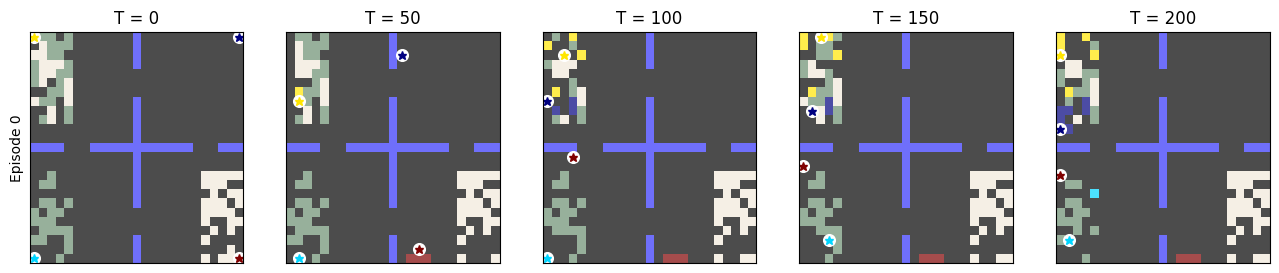

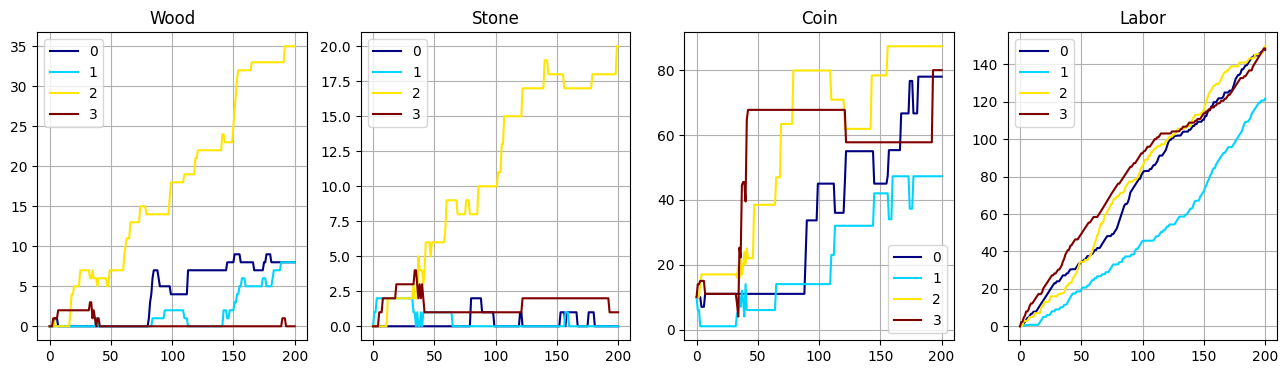

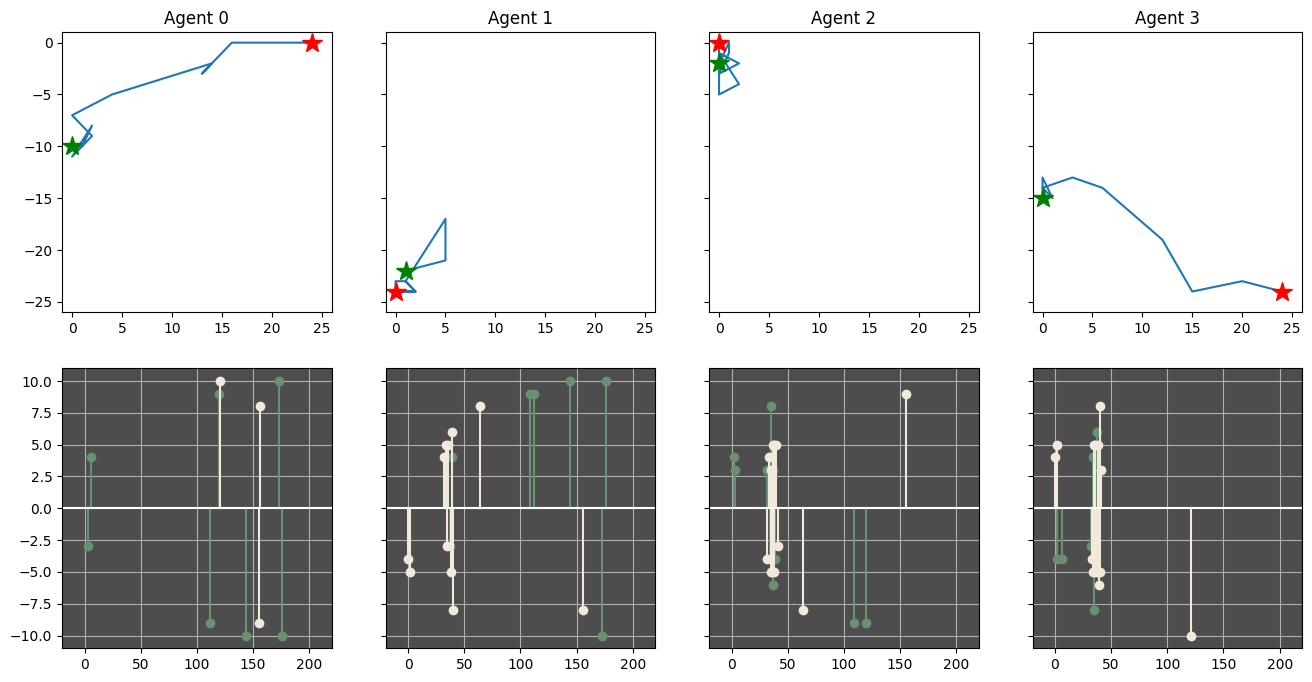

In [80]:
no_dist_df = pd.DataFrame(columns=columns)
#Free market simulation data were obtained as a dataframe using economic_simulation function
no_dist_df = economic_simulation(curri_env, "Free Market", no_dist_df, worker_algorithm, worker_algorithm)
#Free Market simulation analysis
curricilum_dense_log = curri_env.previous_episode_dense_log
result = plotting.breakdown(curricilum_dense_log);

Universal basic Income Polciy Config

In [59]:
ubi_env_config = {
   
    'scenario_name': 'layout_from_file/simple_wood_and_stone',
    'components': [
       
        ('Build', {'skill_dist': "pareto", 'payment_max_skill_multiplier': 1, 'build_labor':1, 'payment': 10}), 
        ('Gather', {'move_labor': 1, 'collect_labor': 1, 'skill_dist' : "pareto"}),
        ('ContinuousDoubleAuction', {
            'max_bid_ask':    10,
            'order_labor':    0.1,
            'max_num_orders': 4,
            'order_duration': 30
        }),
        ("ubi_target_redistribution", {'not_train_planner': False, 'policy_type': "ubi"})
       
    ],
    
    'env_layout_file': 'env-pure_and_mixed-25X25.txt',
    'starting_agent_coin': 10,
    'fixed_four_skill_and_loc': True,
    'full_observability' : True,
    'n_agents': 4,          
    'world_size': [25, 25], 
    'episode_length': 200,
    'energy_warmup_constant': 1000,
    'energy_warmup_method': "auto",
   
    'multi_action_mode_agents': True,
    'multi_action_mode_planner': True,
    
    
    'flatten_observations': False,
    
    'flatten_masks': True,
}
#UBI simulation environment
ubi_env = foundation.make_env_instance(**ubi_env_config)
obs = ubi_env.reset()

In [16]:
import ray
ray.shutdown()

(RolloutWorker pid=31162) Inside covid19_env.py: 0 GPUs are available. [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(RolloutWorker pid=31162) No GPUs found! Running the simulation on a CPU. [repeated 5x across cluster]


(RolloutWorker pid=31162) [W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware. [repeated 2x across cluster]
(RolloutWorker pid=31162) 2023-08-27 19:33:57,749	WARNING catalog.py:632 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']! [repeated 5x across cluster]


In [17]:
ray.init(num_cpus=6, object_store_memory=10**9)

2023-08-27 19:34:14,749	INFO worker.py:1627 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8268 


Python version:,3.11.4
Ray version:,2.5.1
Dashboard:,http://127.0.0.1:8268


In [18]:
#Best UBI planner policy loaded from two level learning
ubi_policy_planner = Algorithm.from_checkpoint("/Users/lokeshwarana/ray_results/PPO/PPO_EconomicsWrapper_b0c3d_00000_0_2023-08-18_10-29-11/checkpoint_000007")

2023-08-27 19:34:15,565	WARNING algorithm_config.py:643 -- Cannot create PPOConfig from given `config_dict`! Property __stdout_file__ not supported.
/Users/lokeshwarana/opt/anaconda3/envs/env11/lib/python3.11/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/lokeshwarana/opt/anaconda3/envs/env11/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cl

(RolloutWorker pid=31240) Inside covid19_components.py: 0 GPUs are available.
(RolloutWorker pid=31240) No GPUs found! Running the simulation on a CPU.
(RolloutWorker pid=31240) Inside covid19_env.py: 0 GPUs are available.
(RolloutWorker pid=31240) No GPUs found! Running the simulation on a CPU.


(RolloutWorker pid=31240) 2023-08-27 19:34:19,601	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.torch.complex_input_net.ComplexInputNetwork` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=31240) [W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
(RolloutWorker pid=31240) 2023-08-27 19:34:19,709	WARNING catalog.py:632 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
(RolloutWorker pid=31240) 2023-08-27 19:34:20,165	WARNING catalog.py:632 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-08-27 19:34:20,344	WARNING catalog.py:632 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-08-27 19:34:20,833	WARNING catalog.py:632 -- Custom ModelV2 should accept all custom options as **kwargs

In [60]:
#dataframe from UBI simulation is collected
df_ubi = pd.DataFrame(columns=columns)
df_ubi = economic_simulation(ubi_env, "UBI", df_ubi, worker_algorithm, ubi_policy_planner)

_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 ____
Cost (Wood)    :   6.07 (n= 14) |   5.53 (n= 15) |   6.50 (n= 22) |   5.54 (n= 13)
Cost (Stone)   :   3.33 (n=  3) |   5.50 (n=  2) |   5.50 (n=  4) |   7.20 (n=  5)

Income (Wood)  :   6.31 (n= 16) |   6.73 (n= 15) |   5.79 (n= 24) |   4.67 (n=  9)
Income (Stone) :   7.20 (n=  5) |   5.20 (n=  5) |   4.00 (n=  3) |   5.00 (n=  1)
Income (Build) :  16.47 (n=  9) |  22.25 (n=  4) |  13.27 (n=  1) |  11.33 (n=  3)


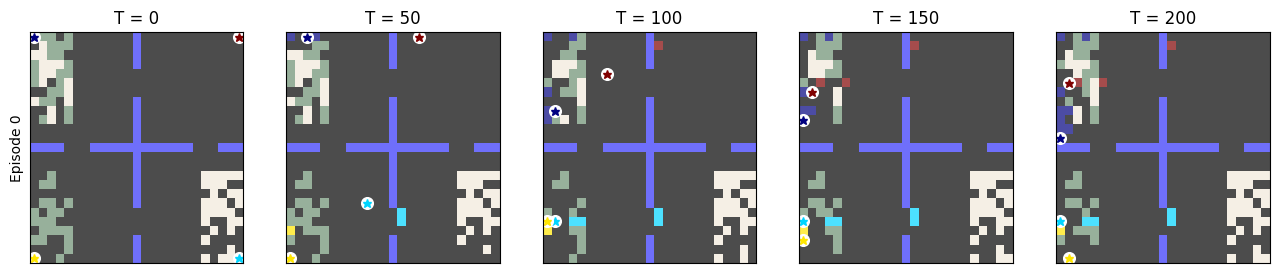

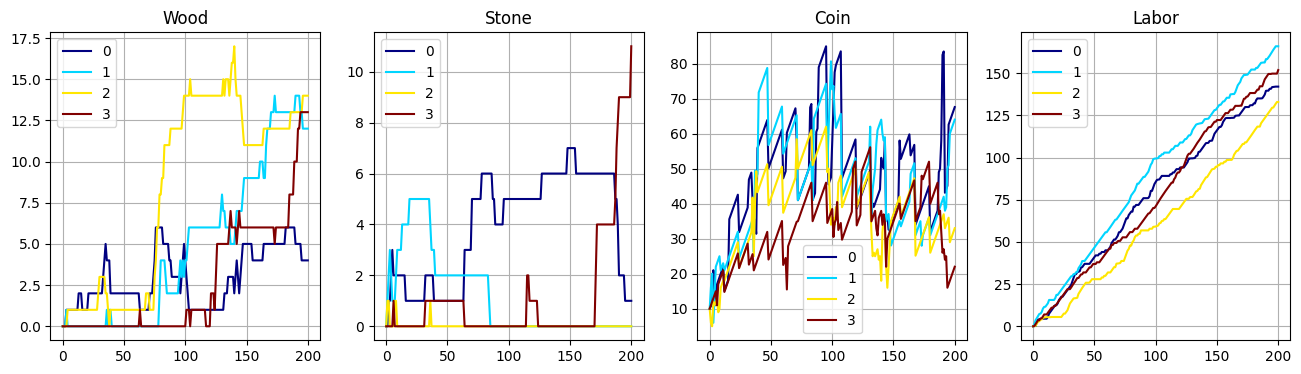

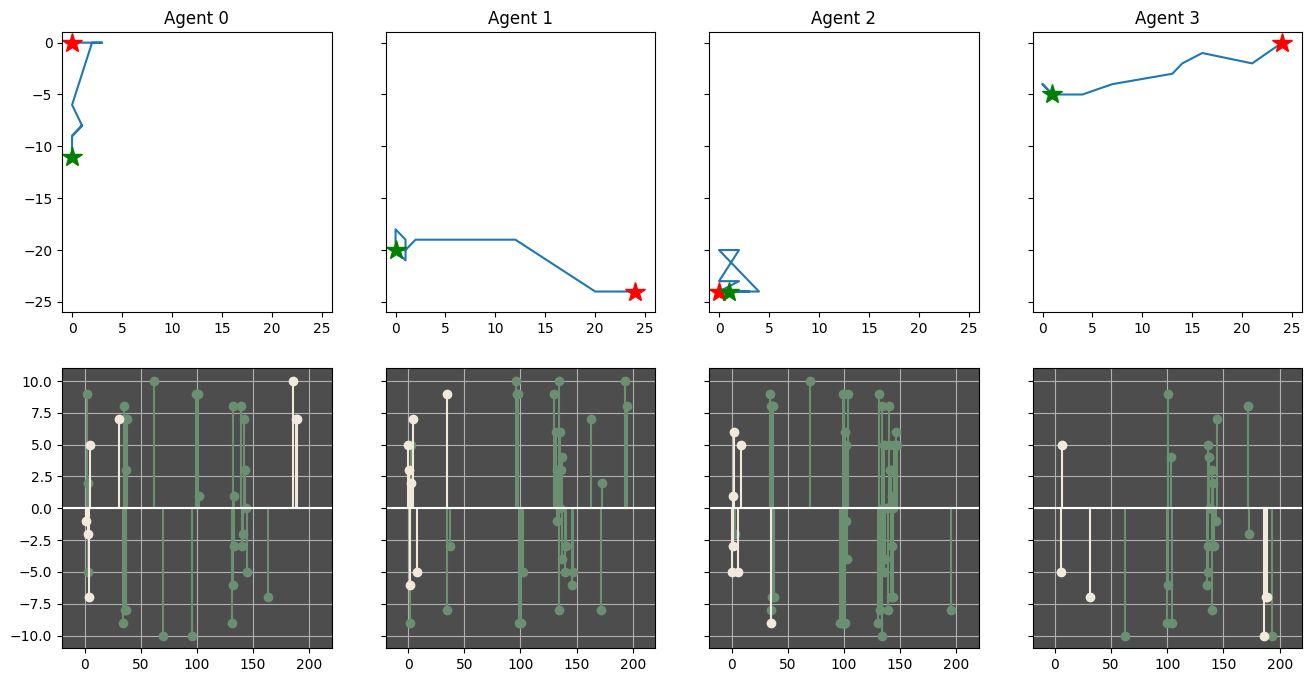

In [61]:
#UBI simulation result
ubi_dense_log = ubi_env.previous_episode_dense_log
ubi_result = plotting.breakdown(ubi_dense_log);

Conditional Cash Transfer program

In [62]:
cct_env_config = {
   
    'scenario_name': 'layout_from_file/simple_wood_and_stone',
    'components': [
       
        ('Build', {'skill_dist': "pareto", 'payment_max_skill_multiplier': 3, 'build_labor':1, 'payment': 10}), 
        ('Gather', {'move_labor': 1, 'collect_labor': 1, 'skill_dist' : "pareto"}),
        ('ContinuousDoubleAuction', {
            'max_bid_ask':    10,
            'order_labor':    0.1,
            'max_num_orders': 4,
            'order_duration': 30
        }),
        ("ubi_target_redistribution", {'not_train_planner': False, 'policy_type': "target_transfer"})
       
    ],
    
    'env_layout_file': 'env-pure_and_mixed-25X25.txt',
    'starting_agent_coin': 10,
    'fixed_four_skill_and_loc': True,
    'full_observability' : True,
    'n_agents': 4,          
    'world_size': [25, 25], 
    'episode_length': 200,

   
    'multi_action_mode_agents': True,
    'multi_action_mode_planner': True,
    
    
    'flatten_observations': False,
    
    'flatten_masks': True,
}
cct_env = foundation.make_env_instance(**cct_env_config)
obs = cct_env.reset()

In [23]:
#CCT policy is loaded from best policy obtained from two-level learning
conditional_transfer_planner = Algorithm.from_checkpoint("/Users/lokeshwarana/ray_results/PPO_EconomicsWrapper_2023-08-16_15-44-3020ram68k/checkpoint_000051")

/Users/lokeshwarana/opt/anaconda3/envs/env11/lib/python3.11/site-packages/ray/rllib/algorithms/algorithm.py:442: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/Users/lokeshwarana/opt/anaconda3/envs/env11/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/Users/lokeshwarana/opt/anaconda3/envs/env11/lib/python3.11/site-packages/ray/tune/logger/unified.py:53: Ray

(RolloutWorker pid=31407) Inside covid19_env.py: 0 GPUs are available. [repeated 2x across cluster]
(RolloutWorker pid=31407) No GPUs found! Running the simulation on a CPU. [repeated 2x across cluster]


(RolloutWorker pid=31405) 2023-08-27 19:35:03,109	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.models.torch.complex_input_net.ComplexInputNetwork` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=31407) [W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.
(RolloutWorker pid=31407) 2023-08-27 19:35:03,274	WARNING catalog.py:632 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-08-27 19:35:04,078	WARNING catalog.py:632 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!
2023-08-27 19:35:04,537	WARNING catalog.py:632 -- Custom ModelV2 should accept all custom options as **kwargs, instead of expecting them in config['custom_model_config']!


In [63]:
cct_df = pd.DataFrame(columns=columns)
cct_df = economic_simulation(cct_env, "CCT", cct_df, worker_algorithm, conditional_transfer_planner)

_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 ____
Cost (Wood)    :   6.93 (n= 14) |   6.27 (n= 15) |   7.13 (n= 15) |   8.13 (n= 15)
Cost (Stone)   :   6.38 (n=  8) |   6.57 (n= 14) |   6.20 (n= 10) |   6.67 (n=  9)

Income (Wood)  :   8.12 (n=  8) |   5.89 (n= 18) |   8.11 (n= 18) |   6.87 (n= 15)
Income (Stone) :   7.57 (n=  7) |   6.50 (n= 10) |   5.81 (n= 16) |   6.75 (n=  8)
Income (Build) :  22.25 (n=  4) |  13.27 (n=  4) |  16.47 (n=  6) |  11.33 (n=  3)


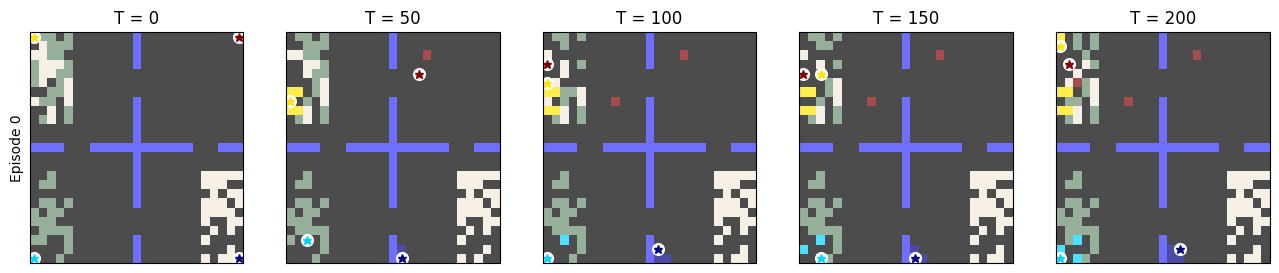

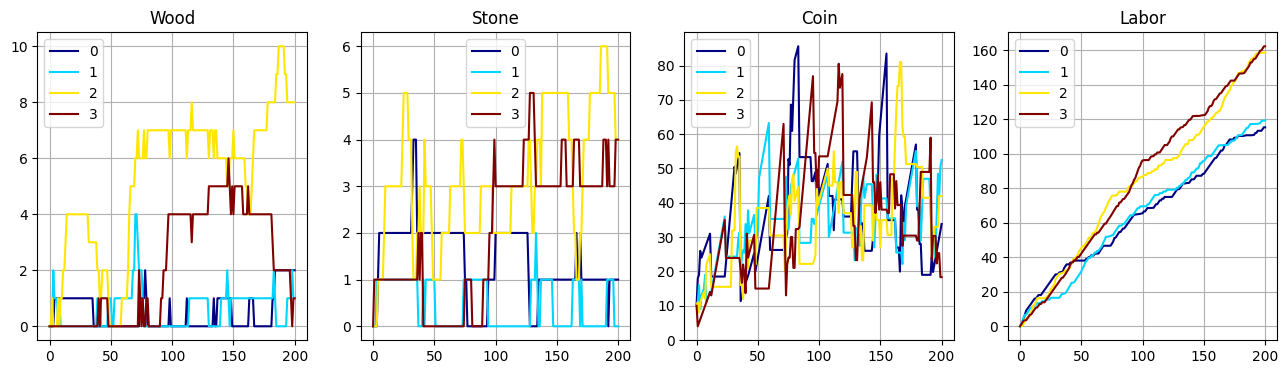

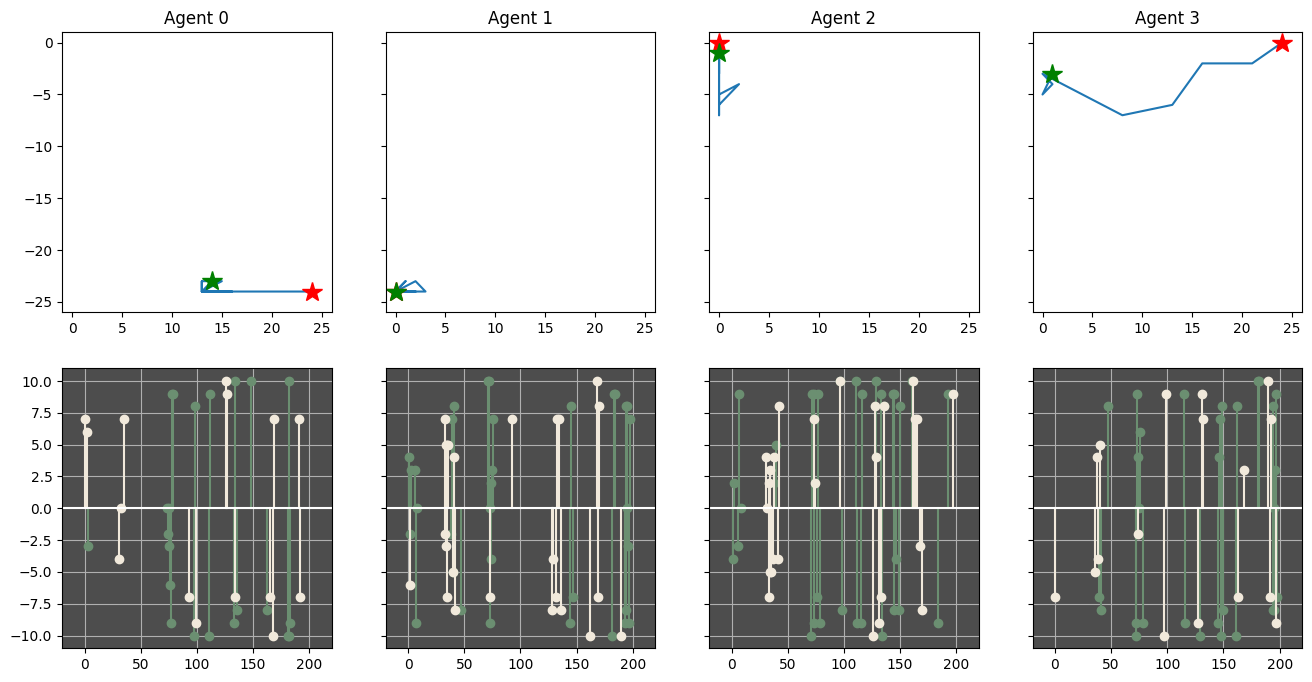

In [64]:
cct_dense_log = cct_env.previous_episode_dense_log
cct_result = plotting.breakdown(cct_dense_log);

In [84]:
#The all policy data were concatenated
df = pd.concat([no_dist_df,df_ubi, cct_df], ignore_index=True)

In [100]:
df.head()

,agent_id,time_step,tax_amount,total_amount,total_earnings,pre_tax_income,post_tax_income,start_tax,base_tax,higher_tax,additional_tax,tax_period,productivity,equality,treasury_amount,policy,equality_X_productivity
0,0,0,0,0,10.0,0,0,0,0.2,0.4,0.5,1,40.0,0.8,0,Free Market,32.0
1,1,0,0,0,6.0,0,0,0,0.2,0.4,0.5,1,40.0,0.8,0,Free Market,32.0
2,2,0,0,0,10.0,0,0,0,0.2,0.4,0.5,1,40.0,0.8,0,Free Market,32.0
3,3,0,0,0,14.0,0,0,0,0.2,0.4,0.5,1,40.0,0.8,0,Free Market,32.0
4,0,1,0,0,10.0,0,0,0,0.2,0.4,0.5,1,40.0,0.8,0,Free Market,32.0


In [315]:
df["policy"].unique()

array(['ubi', 'cct'], dtype=object)

In [41]:
import seaborn as sns

In [40]:
def plot_equality_productivity(data_frame, title):
    ax = sns.scatterplot(data=data_frame, x='productivity', y=(data_frame['equality']*100), hue='policy', palette='Set1', s = 200)
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 100)
    plt.ylabel("Equality Percentage")
    plt.xlabel("Productivity")
    plt.title(title)
    ax.legend(loc='upper left')
    plt.show()

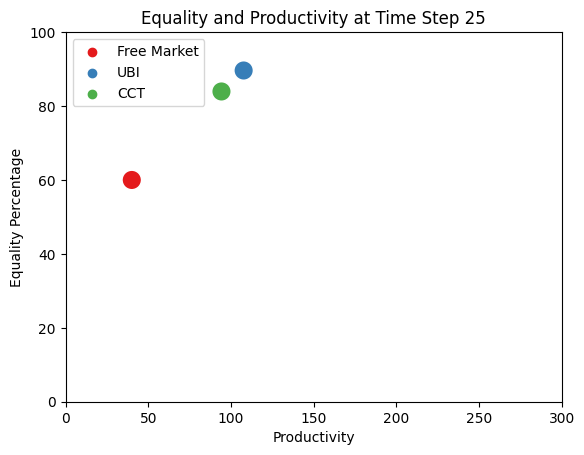

In [95]:
time_step_25 = df[(df["agent_id"] == "0") & (df["time_step"] == 25)]
plot_equality_productivity(time_step_25, "Equality and Productivity at Time Step 25")

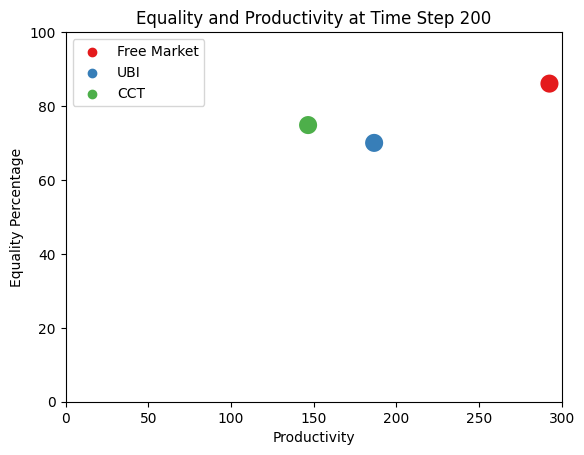

In [94]:
time_step_100 = df[(df["agent_id"] == "0") & (df["time_step"] == 199)]
plot_equality_productivity(time_step_100, "Equality and Productivity at Time Step 200")

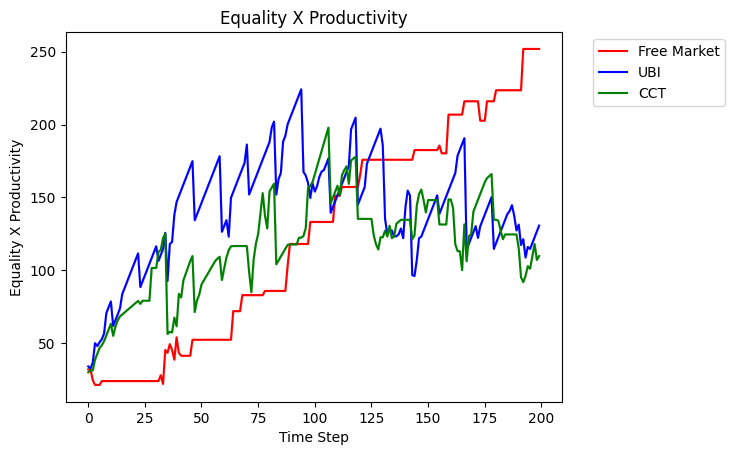

In [93]:
hue_map = {"no_dist": "Team 1", "ubi": "Team 2", "cct" : "Team 3"}
ax = sns.lineplot(data=df, x='time_step', y=(df["equality"] * df["productivity"]), hue='policy', palette=["red", "blue", "green"])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("Equality X Productivity")
plt.xlabel("Time Step")
plt.title("Equality X Productivity")

plt.show()

In [69]:
tax_collected = df[(df["tax_period"] == 1) & (df["policy"] != "Free Market")].groupby(["time_step", "policy"])["tax_amount"].sum()

In [70]:
tax_collected = tax_collected.reset_index()

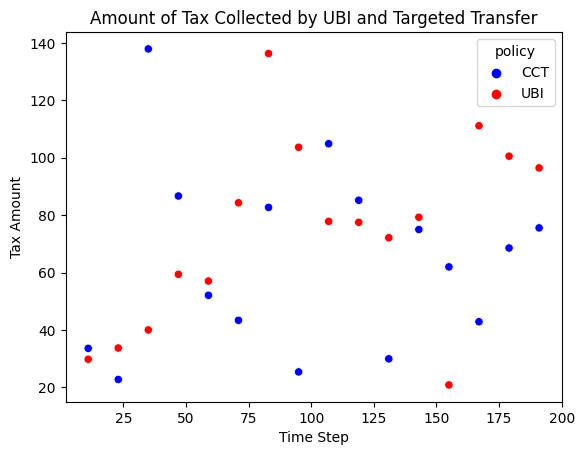

In [96]:
sns.scatterplot(data=tax_collected, x=tax_collected["time_step"], y=tax_collected["tax_amount"], hue="policy", palette=["blue", "red"])
plt.xlabel("Time Step")
plt.ylabel("Tax Amount")
plt.title("Amount of Tax Collected by UBI and CCT policy")
plt.show()

In [108]:

#10 iteration data were collected for Free Market policy
no_dist_df = pd.DataFrame(columns=columns)
for i in range(10):
    curri_env = foundation.make_env_instance(**curr_env_config)
    curri_env.reset()
    no_dist_df_new = economic_simulation(curri_env, "Free Market", no_dist_df, worker_algorithm, worker_algorithm)
    no_dist_df = pd.concat([no_dist_df, no_dist_df_new], ignore_index=True)

In [114]:
#equality and productivity of 10 iteration were averaged for free market
avg_no_dist = no_dist_df.groupby("time_step")[['equality', "productivity"]].mean().reset_index()

In [123]:
avg_no_dist["policy"] = "Free Market"

In [116]:
#10 iteration data were collected for UBI policy
df_ubi = pd.DataFrame(columns=columns)
for i in range(10):
    ubi_env = foundation.make_env_instance(**ubi_env_config)
    ubi_env.reset()
    df_ubi_new = economic_simulation(ubi_env, "UBI", df_ubi, worker_algorithm, ubi_policy_planner)
    df_ubi = pd.concat([df_ubi, df_ubi_new], ignore_index=True)
    

In [117]:
#equality and productivity of 10 iteration were averaged for ubi
avg_ubi = df_ubi.groupby("time_step")[['equality', "productivity"]].mean().reset_index()

In [124]:
avg_ubi["policy"] = "UBI"

In [119]:
#10 iteration data were collected for CCT policy
cct_df = pd.DataFrame(columns=columns)
for i in range(10):
    cct_env = foundation.make_env_instance(**cct_env_config)
    cct_env.reset()
    cct_df_new = economic_simulation(cct_env, "CCT", cct_df, worker_algorithm, conditional_transfer_planner)
    cct_df = pd.concat([cct_df, cct_df_new], ignore_index=True)
    

In [120]:
#equality and productivity of 10 iteration were averaged for cct
avg_cct = cct_df.groupby("time_step")[['equality', "productivity"]].mean().reset_index()

In [125]:
avg_cct["policy"] = "CCT"

In [126]:
df = pd.concat([avg_no_dist,avg_ubi, avg_cct], ignore_index=True)

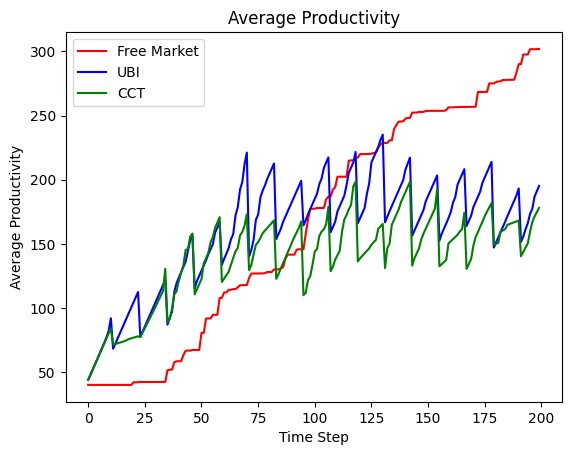

In [132]:
#Average productivity
ax = sns.lineplot(data=df, x='time_step', y='productivity', hue='policy', palette=["red", "blue", "green"])
plt.ylabel("Average Productivity")
plt.xlabel("Time Step")
plt.title("Average Productivity")
ax.legend(loc='upper left')
plt.show()

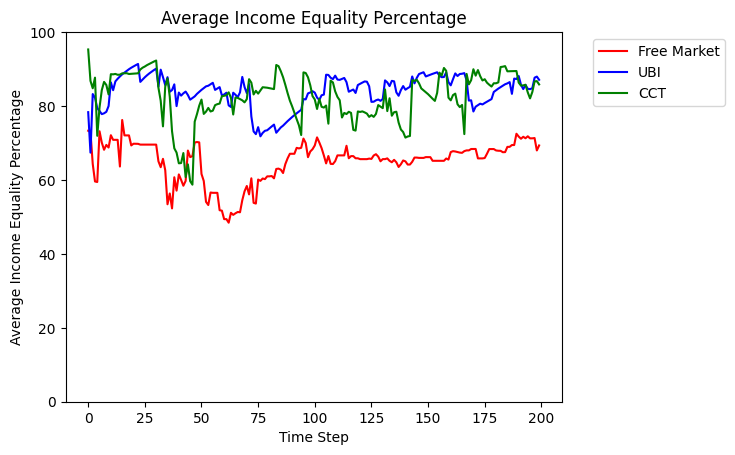

In [133]:
#average income equality percentage
ax = sns.lineplot(data=df, x='time_step', y=(df["equality"] * 100), hue='policy', palette=["red", "blue" ,"green"])
ax.set_ylim(0, 100)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("Average Income Equality Percentage")
plt.xlabel("Time Step")
plt.title("Average Income Equality Percentage")
plt.show()